In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})

print(os.getpid())
%cd ../../

21724
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.qucf_oracle as qucf_o
import pylib.qucf_matrix_D as qucf_m
import ASE as ase
import pylib.qsvt_angles as qsvt_a

for i in range(30):
    plt.close()

In [4]:
# ---------------------------------------------------------------
# --- Read data ---
# ---------------------------------------------------------------
mix.reload_module(ase)

print("\n--- Creating the object with data... ---")
data_ = ase.ASE_()

print("\n--- Reading matrices D from quantum simulations ---")
data_.read_D_matrices()

print("\n\n--- Reading matrices of the considered 1D kinetic problem --") 
data_.read_plasma_matrices()

print("--- Creating a template to extrapolate the matrix D for larger sizes ---") 
data_.create_D_template()


--- Creating the object with data... ---

--- Reading matrices D from quantum simulations ---

Reading the matrix from: flat_33_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 09:51:13
matrix name:  U_BE
N = 128

Reading the matrix from: flat_44_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 08:57:47
matrix name:  U_BE
N = 512

Reading the matrix from: flat_45_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:42:09
matrix name:  U_BE
N = 1024

Reading the matrix from: flat_54_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:48:52
matrix name:  U_BE
N = 1024


--- Reading matrices of the considered 1D kinetic problem --

Reading data from out_3_3_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  06-22-2023 15:48:52
N, nx, nv = 128, 3, 3
Done.

Reading data from out_4_4_w1.2_Lx10

In [72]:
# --------------------------------------------------------------------
# --- Choose a case (matrix size) with which you are going to work ---
# --------------------------------------------------------------------
data_.choose_a_case(nx = 4, nv = 4)

original matrix >>>
amax. value: 			4.000e+00
amin.(excl. zero) value: 	2.855e-04

norm of the matrix:  9.907124260405292

normalized matrix >>>
amax. value: 			3.552e-03
amin.(excl. zero) value: 	2.535e-07



In [73]:
# ------------------------------------------------------------------------------------------
# --- [OPTIONAL] Compare the reconstructed matrix D with the calculated one if available ---
# ------------------------------------------------------------------------------------------
data_.DF_work_.is_the_same_as(
    data_.get_original_D_matrix(), 
    data_.circ_.prec_
)

The matrices are the same


In [74]:
for i in range(30):
    plt.close()

In [78]:
# -----------------------------------------------
# --- Computation of the oracle's angles ---
# -----------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_o)

# -----------------------------------------------------------------------------------------------
def compute_correction_matrices(sys_gates, B_init_sparse, flag_last_iter):
    if not flag_last_iter:
        sys_gates.remove_small_groups()
        print("\n--- After removing small groups ---")
        sys_gates.count_groups()
        Ca_dense, Cv_dense = sys_gates.form_corr_matrices(B_init_sparse)
        Cv_sparse = mix.form_sparse_matrix(Cv_dense)
        Ca_sparse = mix.form_sparse_matrix(Ca_dense)
        print("N-nonzero in B-init: ", B_init_sparse.get_Nnz())
        print("N-nonzero in C: ", Cv_sparse.get_Nnz())

        # sys_gates.form_grid_groups(B_init_sparse)
        # print("N-nonzero in B-rec: ",  sys_gates.reconstruct_matrix_using_GRID().get_Nnz())

        print()
        print("--- Matrix with correcting angles ---")
        mix.plot_structure_simple(Cv_sparse, flag_plots = flag_plots)
        return Ca_sparse, Cv_sparse, sys_gates
    else:
        sys_gates.form_grid_groups(B_init_sparse)
        return None, None, sys_gates


# -----------------------------------------------------------------------------------------------
def first_iteration(B_init_sparse, flag_last_iter):
    # --- Splitting the matrix into diagonals ---
    grid_sections = qucf_o.create_grid_of_sections(data_.circ_, B_init_sparse)

    # --- Creating sections of sets (sets := groups) ---
    sys_gates = qucf_o.SystemGates__(
        data_.circ_, 
        qucf_o.create_groups_neighbor(data_.circ_, grid_sections) 
    )
    print("--- Initial number of groups ---")
    sys_gates.count_groups()
    print()

    # sys_gates.set_rows_limit_for_non_extension(1<<data_.nv_work_)
    sys_gates.set_rows_limit_for_non_extension(4)

    print("Nr-small: ", sys_gates.Nr_small_)

    # --- Recreate the matrix using the ORIGINAL groups ---
    print("--- Reconstruction using original groups ---")
    B_int_rec = sys_gates.reconstruct_matrix_using_GROUPS()
    B_int_rec.is_the_same_as(B_init_sparse, prec = data_.circ_.prec_)
    print("N-nonzero in B-rec using nonextended groups: ", B_int_rec.get_Nnz())
    del B_int_rec

    # # Split groups (optional):
    # sys_gates.n_split_ = 0
    # sys_gates.split_groups()
    # sys_gates.split_groups()
    # sys_gates.split_groups()
    # sys_gates.split_groups()
    # sys_gates.split_groups()
    # print("--- After the splitting ---")
    # sys_gates.count_groups()

    # --- Sorting groups ---
    sys_gates.sort_groups()

    print("Nr-small: ", sys_gates.Nr_small_)

    # --- Extending sorted groups ----
    sys_gates.extend_sorted_groups(B_init_sparse)
    print("\n--- After extending large groups ---")
    sys_gates.count_groups()
    sys_gates.count_small_large_groups()
    print()

    # --- Merging groups ---
    sys_gates.merge_groups()
    print("--- After the merging ---")
    sys_gates.count_groups()
    print()

    # --- Preliminary correction ---
    sys_gates.correct_close_groups()

    # ---
    return compute_correction_matrices(sys_gates, B_init_sparse, flag_last_iter)
    

# -----------------------------------------------------------------------------------------------
def next_iteration(B_init_sparse, Ca_sparse, Cv_sparse, sys_gates, flag_last_iter):

    # --- Find the groups representing the correcting angles ---
    grid_sections = qucf_o.create_grid_of_sections(data_.circ_, Cv_sparse)
    sys_gates_corr = qucf_o.SystemGates__(
        data_.circ_, 
        qucf_o.create_groups_neighbor(
            data_.circ_, 
            grid_sections, 
            supp_matrix = Ca_sparse
        ) 
    )
    sys_gates_corr.sort_groups()
    sys_gates_corr.extend_sorted_groups(B_fixed = Cv_sparse)
    sys_gates_corr.merge_groups()
    sys_gates_corr.correct_close_groups()

    # --- Add the correcting groups to the original groups ---
    sys_gates.add_groups(sys_gates_corr)
    # sys_gates.merge_groups()
    # sys_gates.correct_close_groups()

    # ---
    return compute_correction_matrices(sys_gates, B_init_sparse, flag_last_iter)
# ---------------------------------------------------------------------------------

# --- Parameters ---
flag_plots = False
N_iter = 2

# --- Parameters of the target matrix ---
B_orig_dense = data_.BF_fixed_.get_dense_matrix()
N = B_orig_dense.shape[0]
mix.plot_structure_simple(B_orig_dense, flag_plots)

# --- Find the first approximation of the target matrix by groups ---
print()
print("---------------------------------------------------------------")
print("--- The first iteration. ---")
print("---------------------------------------------------------------")
flag_last_iter = False
if N_iter == 0 or N_iter == 1:
    flag_last_iter = True
Ca_sparse_, Cv_sparse_, sys_gates_ = first_iteration(data_.BF_fixed_, flag_last_iter)

# --- Next iterations ---
for i_iter in range(1,N_iter):
    print()
    if i_iter == N_iter - 1:
        flag_last_iter = True
        print("---------------------------------------------------------------")
        print("--- The Last iteration: ({:d}) ---".format(i_iter+1))
        print("---------------------------------------------------------------")
    else:
        print("---------------------------------------------------------------")
        print("--- Iteration: {:d} ---".format(i_iter+1))
        print("---------------------------------------------------------------")
    Ca_sparse_, Cv_sparse_, sys_gates_ = next_iteration(
        data_.BF_fixed_, Ca_sparse_, Cv_sparse_, sys_gates_, flag_last_iter
    )
print()
print("***************************************************")
print("--- The final grid of groups ---")
sys_gates_.count_groups()
print()

# --- Recreate the matrix using the CORRECTED groups ---
print("--- Reconstruction using corrected groups ---")
sys_gates_.reconstruct_matrix_using_GRID().is_the_same_as(
    data_.BF_fixed_, 
    prec = data_.circ_.prec_
)

# --- Construct the circuit ---
print("\n--- Circuit construction ---")
print("N-nonzero-elements in the flat-elements-matrix: ", int(data_.BF_fixed_.get_Nnz()))
sys_gates_.construct_circuit_OH(
    data_.path_qc_, 
    data_.file_name_oracle_
)
print()

del N, flag_plots, N_iter


---------------------------------------------------------------
--- The first iteration. ---
---------------------------------------------------------------
--- Initial number of groups ---
Number of groups: 128

Nr-small:  4
--- Reconstruction using original groups ---
The matrices are the same
N-nonzero in B-rec using nonextended groups:  784
Nr-small:  4

--- After extending large groups ---
Number of groups: 128
Number of small groups: 94
Number of large groups: 34

--- After the merging ---
Number of groups: 118


--- After removing small groups ---
Number of groups: 24


/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


N-nonzero in B-init:  784
N-nonzero in C:  222

--- Matrix with correcting angles ---

---------------------------------------------------------------
--- The Last iteration: (2) ---
---------------------------------------------------------------

***************************************************
--- The final grid of groups ---
Number of groups: 315

--- Reconstruction using corrected groups ---
The matrices are the same

--- Circuit construction ---
N-nonzero-elements in the flat-elements-matrix:  784
N-gates: 472
N-gates (assuming Rc as a single gate): 239



In [71]:
print(2406/246)
print(2649/489)

print(2175/460)

print(np.sqrt(1<<(8-4)))

9.78048780487805
5.41717791411043
4.728260869565218
4.0



fit: nx = 4
[142.541   4.975]

fit: nx = 5
[286.541   4.975]

fit: nx = 6
[574.453   4.983]

fit: nx = 7
[1150.541    4.975]

fit: nx = 8
[2166.523    7.228]


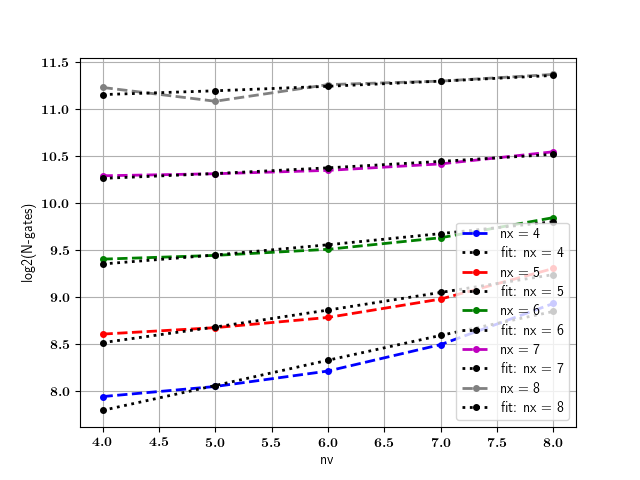


fit: nv = 4
[ 1.02e+02 -4.48e-14  9.00e+00]

fit: nv = 5
[-54.255  54.199   5.345]

fit: nv = 6
[ 1.530e+02 -6.663e-14  9.000e+00]

fit: nv = 7
[216.169   0.267   8.986]

fit: nv = 8
[ 3.45e+02 -1.24e-13  9.00e+00]


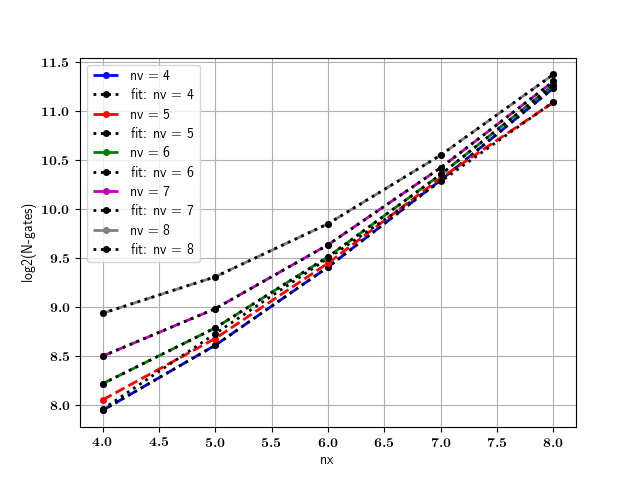

In [34]:
# -------------------------------------------------------------------------
# --- PLOT the scan: N-gates vs Nnz ---
# -------------------------------------------------------------------------
import cvxpy as cp

def plot_scaling():
    

    def get_fitting_curve(Nc, x, y, sel_fit):
        def fit_n(x, coefs):
            res_pol = coefs[0]
            for ii in range(1, Nc):
                res_pol += coefs[ii] * x**ii
            return res_pol
        # ------------------------------------
        def fit_2n(x, coefs):
            res_pol = coefs[0]
            for ii in range(1, Nc):
                res_pol += coefs[ii] * x**(2*ii)
            return res_pol
        # ------------------------------------
        def fit_N(x, coefs):
            res_pol = coefs[0]
            for ii in range(1, Nc):
                res_pol += coefs[ii] * (1<<x)**ii
            return res_pol
        # ------------------------------------
        def fit_sqrt_N(x, coefs):
            res_pol = coefs[0]
            for ii in range(1, Nc):
                res_pol += coefs[ii] * (1<<x)**(ii/2.)
            return res_pol
        # ------------------------------------
        if sel_fit == 0:
            test_func = lambda coords, coefs: fit_n(coords, coefs)
        if sel_fit == 1:
            test_func = lambda coords, coefs: fit_2n(coords, coefs)
        if sel_fit == 2:
            test_func = lambda coords, coefs: fit_N(coords, coefs)
        if sel_fit == 3:
            test_func = lambda coords, coefs: fit_sqrt_N(coords, coefs)


        coefs = cp.Variable(Nc)
        objective = cp.Minimize(cp.sum_squares(y - test_func(x, coefs)))
        prob   = cp.Problem(objective)
        result = prob.solve()
        y_fit  = test_func(x, coefs.value)
        return y_fit, coefs.value
    # -------------------------------------------------------




    scaling_gates_nx4 = np.array([
    # nx, nv, N_nonzero, N_gates (Rc as 1)
        [4,  4,       784,    246],
        [4,  5,      1536,    265],
        [4,  6,      3040,    297],
        [4,  7,      6048,    361],
        [4,  8,     12064,    489],
    ])
    scaling_gates_nx5 = np.array([    
        [5,  4,      1584,    390],
        [5,  5,      3104,    409],
        [5,  6,      6144,    441],
        [5,  7,     12224,    505],
        [5,  8,     24384,    633]
    ])
    scaling_gates_nx6 = np.array([
        [6,  4,      3184,    678],
        [6,  5,      6240,    697],
        [6,  6,     12352,    729],
        [6,  7,     24576,    794],
        [6,  8,     49024,    921],
    ])
    scaling_gates_nx7 = np.array([
        [7, 4,       6384,   1254],
        [7, 5,      12512,   1273],
        [7, 6,      24768,   1305],
        [7, 7,      49280,   1369],
        [7, 7,      98304,   1497]
    ])
    scaling_gates_nx8 = np.array([   
        [8, 4,      12784,   2406],
        [8, 5,      25056,   2173],
        [8, 6,      49600,   2457],
        [8, 7,      98688,   2521],
        [8, 8,     196864,   2649]
    ])

    array_nx = np.array([4,5,6,7,8])
    array_nv = np.array([4,5,6,7,8])

    scan_nx_nv__Ng = np.array([
        scaling_gates_nx4[:, 3],
        scaling_gates_nx5[:, 3],
        scaling_gates_nx6[:, 3],
        scaling_gates_nx7[:, 3],
        scaling_gates_nx8[:, 3],
    ])
    scan_nx_nv__Nnz = np.array([
        scaling_gates_nx4[:, 2],
        scaling_gates_nx5[:, 2],
        scaling_gates_nx6[:, 2],
        scaling_gates_nx7[:, 2],
        scaling_gates_nx8[:, 2],
    ])

    colors = ["b", "r", "g", "m", "gray"]


    res_Nnz_Ng = {}
    res_Ng_nv = {}
    res_Ng_nx = {}

    # --- PLOT the scan on Nz ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for ii in range(len(array_nx)):
        ax.plot(
            np.log2(scan_nx_nv__Nnz[ii]), np.log2(scan_nx_nv__Ng[ii]), 
            colors[ii], linewidth = 2, linestyle='--',    
            marker='o', markersize=4, 
            label='nx = {:d}'.format(array_nx[ii])
        )
        res_Nnz_Ng[array_nx[ii]] = [
            np.log2(scan_nx_nv__Nnz[ii]),
            np.log2(scan_nx_nv__Ng[ii])
        ]
    plt.xlabel('log2(N-nz)')
    plt.ylabel("log2(N-gates)")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- PLOT the scan of Ng on nv ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for ii in range(len(array_nx)):
        ax.plot(
            array_nv, np.log2(scan_nx_nv__Ng[ii]), 
            colors[ii], linewidth = 2, linestyle='--',    
            marker='o', markersize=4, 
            label='nx = {:d}'.format(array_nx[ii])
        )

        y_fit, coefs = get_fitting_curve(2, array_nv, scan_nx_nv__Ng[ii], 1)
        ax.plot(
            array_nv, np.log2(y_fit), 
            "black", linewidth = 2, linestyle=':',    
            marker='o', markersize=4, 
            label='fit: nx = {:d}'.format(array_nx[ii])
        )
        print()
        print('fit: nx = {:d}'.format(array_nx[ii]))
        print(coefs)

        res_Ng_nv[array_nx[ii]] = [
            np.log2(scan_nx_nv__Ng[ii]),
            np.log2(y_fit),
            coefs
        ]

    plt.xlabel('nv')
    plt.ylabel("log2(N-gates)")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- PLOT the scan of Ng on nx ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for ii in range(len(array_nv)):
        ax.plot(
            array_nx, np.log2(scan_nx_nv__Ng[:,ii]), 
            colors[ii], linewidth = 2, linestyle='--',    
            marker='o', markersize=4, 
            label='nv = {:d}'.format(array_nv[ii])
        )

        y_fit, coefs = get_fitting_curve(3, array_nx, scan_nx_nv__Ng[:,ii], 3)
        ax.plot(
            array_nx, np.log2(y_fit), 
            "black", linewidth = 2, linestyle=':',    
            marker='o', markersize=4, 
            label='fit: nv = {:d}'.format(array_nv[ii])
        )
        print()
        print('fit: nv = {:d}'.format(array_nv[ii]))
        print(coefs)

        res_Ng_nx[array_nv[ii]] = [
            np.log2(scan_nx_nv__Ng[:,ii]),
            np.log2(y_fit),
            coefs
        ]
    plt.xlabel('nx')
    plt.ylabel("log2(N-gates)")
    ax.legend()
    plt.grid(True)
    plt.show()


    # # --- PLOT the scan of Nnz on nv ---
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # for ii in range(len(array_nx)):
    #     ax.plot(
    #         array_nv, np.log2(scan_nx_nv__Nnz[ii]), 
    #         colors[ii], linewidth = 2, linestyle='--',    
    #         marker='o', markersize=4, 
    #         label='nx = {:d}'.format(array_nx[ii])
    #     )
    # plt.xlabel('nv')
    # plt.ylabel("log2(N-nz)")
    # ax.legend()
    # plt.grid(True)
    # plt.show()


    # # --- PLOT the scan of Nnz on nx ---
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # for ii in range(len(array_nv)):
    #     ax.plot(
    #         array_nx, np.log2(scan_nx_nv__Nnz[:,ii]), 
    #         colors[ii], linewidth = 2, linestyle='--',    
    #         marker='o', markersize=4, 
    #         label='nv = {:d}'.format(array_nv[ii])
    #     )
    # plt.xlabel('nx')
    # plt.ylabel("log2(N-nz)")
    # ax.legend()
    # plt.grid(True)
    # plt.show()
    return array_nv, array_nx, res_Nnz_Ng, res_Ng_nv, res_Ng_nx
# ---------------------------------------------
array_nv, array_nx, res_Nnz_Ng, res_Ng_nv, res_Ng_nx = plot_scaling()


In [11]:
# -------------------------------------------------------------------------
# --- Save the scan ---
# -------------------------------------------------------------------------
mix.reload_module(mix)

for ii in range(len(array_nx)):
    nx1 = array_nx[ii]
    mix.save_dat_plot_1d_file(
        data_.path_save_ + "/scan_N_gates_nx{:d}_with_Nnz.dat".format(nx1),    
        res_Nnz_Ng[nx1][0], 
        res_Nnz_Ng[nx1][1]
    )

for ii in range(len(array_nx)):
    nx1 = array_nx[ii]
    mix.save_dat_plot_1d_file(
        data_.path_save_ + "/scan_N_gates_nx{:d}_with_nv.dat".format(nx1),    
        array_nv, 
        res_Ng_nv[nx1][0]
    )
    mix.save_dat_plot_1d_file(
        data_.path_save_ + "/scan_N_gates_nx{:d}_with_nv_FIT.dat".format(nx1),    
        array_nv, 
        res_Ng_nv[nx1][1]
    )

for ii in range(len(array_nv)):
    nv1 = array_nv[ii]
    mix.save_dat_plot_1d_file(
        data_.path_save_ + "/scan_N_gates_nv{:d}_with_nx.dat".format(nv1),    
        array_nx, 
        res_Ng_nx[nv1][0]
    )
    mix.save_dat_plot_1d_file(
        data_.path_save_ + "/scan_N_gates_nv{:d}_with_nx_FIT.dat".format(nv1),    
        array_nx, 
        res_Ng_nx[nv1][1]
    )

del ii, nx1, nv1

write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx4.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx5.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx6.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx7.dat
write data to a file: ../results/KIN1D1D-results/figs//scan_N_gates_nx8.dat


In [ ]:
# # -------------------------------------------------------------------------
# # --- Save the scan ---
# # -------------------------------------------------------------------------
# mix.reload_module(mix)

# nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx4)
# mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx4.dat",    log_Nnz_array, log_N_gates_array)

# nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx5)
# mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx5.dat",    log_Nnz_array, log_N_gates_array)

# nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx6)
# mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx6.dat",    log_Nnz_array, log_N_gates_array)

# nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx7)
# mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx7.dat",    log_Nnz_array, log_N_gates_array)

# nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array = get_data_for_one_nx(scaling_gates_nx8)
# mix.save_dat_plot_1d_file(data_.path_save_ + "/scan_N_gates_nx8.dat",    log_Nnz_array, log_N_gates_array)


# del nx_chosen, Nv_array, log_Nnz_array, log_N_gates_array

In [24]:
# -------------------------------------------------------------------------------------------------------------
# --- [OPTIONAL] Compare the matrix obtained from QC simulation of the oracle with the block-encoded matrix ---
# -------------------------------------------------------------------------------------------------------------
mix.reload_module(qucf_r)
mix.reload_module(ase)

dd_res = qucf_r.read_matrix_sparse(
    data_.path_qc_, data_.output_qucf_
) 
A_F_recon = dd_res["A"].get_slice(0, 0, data_.Nvar_work_)
B_fixed_recon, _ = ase.extract_fixed_profile_matrix_from_F(
    data_.nx_work_, data_.nv_work_, A_F_recon, data_.DF_work_
) 
B_fixed_recon.is_the_same_as(data_.BF_fixed_, prec = 1e-10)
del A_F_recon, B_fixed_recon

Reading the matrix from: BE_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/
date of the simulation:  01-28-2024 12:10:04
matrix name:  U_BE
N = 512
The matrices are the same


In [35]:
# # -----------------------------------------------
# # --- Computation of the oracle's angles ---
# # -----------------------------------------------
# mix.reload_module(mix)
# mix.reload_module(qucf_o)


# print("N, Nx, Nv: {:d}, {:d}, {:d}".format(
#     data_.BF_fixed_.get_N(), 
#     1<<data_.nx_work_, 
#     1<<data_.nv_work_
# ))
# print()

# # Split the matrix into diagonals:
# grid_sections = qucf_o.create_grid_of_sections(
#     data_.circ_, 
#     data_.BF_fixed_
# )

# # -- Create sections of sets (sets := groups):
# sys_gates_ = qucf_o.SystemGates__(
#     data_.circ_, 
# #     qucf_o.create_groups(data_.circ_, grid_sections)            # Option 1
#     qucf_o.create_groups_neighbor(data_.circ_, grid_sections) # Option 2
# )
# print("--- Initial number of groups ---")
# sys_gates_.count_groups()


# # Recreate the matrix using the ORIGINAL groups
# print("--- Reconstruction using original groups ---")
# sys_gates_.reconstruct_matrix_using_GROUPS().is_the_same_as(
#     data_.BF_fixed_, 
#     prec = data_.circ_.prec_
# )

# # # Split groups (optional):
# # sys_gates_.n_split_ = 1
# # sys_gates_.split_groups()
# # sys_gates_.split_groups()
# # sys_gates_.split_groups()
# # sys_gates_.split_groups()
# # sys_gates_.split_groups()
# # print("--- After the splitting ---")
# # sys_gates_.count_groups()

# # Sort groups:
# sys_gates_.sort_groups()

# # Extend the gates:
# sys_gates_.set_rows_limit_for_non_extension(4)
# sys_gates_.extend_sorted_groups(data_.BF_fixed_)

# # merge groups:
# sys_gates_.merge_groups()
# print("\n--- After the merging ---")
# sys_gates_.count_groups()

# # preliminary correction (optional):
# sys_gates_.correct_close_groups()

# # add correcting groups:
# sys_gates_.form_grid_groups(data_.BF_fixed_)
# print("--- After adding the correcting groups ---")
# sys_gates_.count_groups()

# # Recreate the matrix using the CORRECTED groups
# print("--- Reconstruction using corrected groups ---")
# sys_gates_.reconstruct_matrix_using_GRID().is_the_same_as(
#     data_.BF_fixed_, 
#     prec = data_.circ_.prec_
# )

# # Construct the circuit:
# print("\n--- Circuit construction ---")
# print("N-nonzero-elements in the flat-elements-matrix: ", int(data_.BF_fixed_.get_Nnz()))
# sys_gates_.construct_circuit_OH(
#     data_.path_qc_, 
#     data_.file_name_oracle_
# )

N, Nx, Nv: 256, 16, 16

--- Initial number of groups ---
Number of groups: 128

--- Reconstruction using original groups ---
The matrices are the same

--- After the merging ---
Number of groups: 118

--- After adding the correcting groups ---
Number of groups: 340

--- Reconstruction using corrected groups ---
The matrices are the same

--- Circuit construction ---
N-nonzero-elements in the flat-elements-matrix:  784
N-gates: 486
N-gates (assuming Rc as a single gate): 246


/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/media/work/docs/codes/QuCF/scripts-py/env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
